In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tensorflow as tf
import tensorflow_io as tfio
import os
from tqdm import tqdm
import cv2
from PIL import Image
from joblib import Parallel, delayed
import gc
from PIL import Image as im
import random

In [2]:
import sys
!{sys.executable} -m pip install dicomsdl
#!pip install /kaggle/input/rsnapacks/dicomsdl-0.109.1-cp36-cp36m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
#import pydicom as dicom
import dicomsdl as dicom
import tensorflow as tf
import tensorflow_io as tfio
from PIL import Image as im
import os
from tqdm import tqdm
import cv2
from PIL import Image
from joblib import Parallel, delayed
import gc
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.5 MB/s eta 0:00:00


In [3]:
datasetPath = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
imgPath = '/kaggle/input/rsna-breast-cancer-detection/train_images/'

def crop(sideName, imgName):
    """
    This function is used to crop the breast images. It takes two arguments.
    
    Input:-
    :sideName = Laterality of breast if it is right or left
    :imgName = Image pixel data of the DCM images
    
    Output:-
    :return = Output after cropping the image.
    
    """
    if sideName == 'L':
        colind=[]
        for r,row in enumerate(imgName):
            for c,col in enumerate(row):
                if col==0:
                    colind.append(c)
                    break
        crop_size = max(colind)
        imgName = imgName[0:512,0:crop_size]
        imgName = cv2.resize(imgName,(128,128))
        
    if sideName == 'R':
        colind=[]
        for r,row in enumerate(imgName):
            for c,col in enumerate(row):
                if col!=0:
                    colind.append(c)
                    break
        crop_size = min(colind)
        imgName = imgName[0:512,crop_size:512]
        imgName = cv2.resize(imgName,(128,128))
    
    return imgName    

    gc.collect()
    
def crop_reverse(sideName, imgName):
    
    """
    This function is used to crop the breast images but in the reverse order.
    Because the laterality is defined wrongly for some images. It takes two arguments.
    
    Input:-
    :sideName = Laterality of breast if it is right or left
    :imgName = Image pixel data of the DCM images
    
    Output:-
    :return = Output after cropping the image.
    
    """
    
    if sideName == 'R':
        colind=[]
        for r,row in enumerate(imgName):
            for c,col in enumerate(row):
                if col==0:
                    colind.append(c)
                    break
        crop_size = max(colind)
        imgName = imgName[0:512,0:crop_size]
        imgName = cv2.resize(imgName,(128,128))
        
    if sideName == 'L':
        colind=[]
        for r,row in enumerate(imgName):
            for c,col in enumerate(row):
                if col!=0:
                    colind.append(c)
                    break
        crop_size = min(colind)
        imgName = imgName[0:512,crop_size:512]
        imgName = cv2.resize(imgName,(128,128))
    
    return imgName    

    gc.collect()
    

def img_process(i,filename,sides):
    
    """
    This function is used to process the images which will be used for the training/test dataset. It takes three arguments.
    
    Input:-
    :i = Index of the image in the dataframe
    :filename = Path of the image
    :sides = List of all images' laterality
    
    Output:-
    :return = Output after cropping the image.
    
    """
    
    
    #ds = dicom.dcmread(filename)
    dsraw = dicom.open(filename)
    ds = dsraw.pixelData()
    
    ds = (ds - ds.min()) / (ds.max() - ds.min())
    if dsraw.PhotometricInterpretation == "MONOCHROME1":  
        ds = 1 - ds
    ds = (ds * 255).astype(np.uint8)

    
    #ds = cv2.normalize(ds, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    ds = cv2.resize(ds,(512,512))
    
    #ds = np.where(ds >= 0.999, 0,ds)
    
    try:
        ds = np.array(crop(sides[i], ds))   
    except:
        ds = np.array(crop_reverse(sides[i], ds))
    

    #train_data.loc[i,'img_data'] = [img_fin]
    #train_data.to_csv('/kaggle/working/training_img_data.csv') 
    return ds
    gc.collect()

def dcmToPix(datasetPath, imgPath):
    
    """
    This function is used to process all the images which will be used for the training/test dataset. It takes two arguments.
    
    Input:-
    :datasetPath = Path of the cancer dataset
    :imgPath = Path of the image dataset
   
    Output:-
    :return = Array of all the processed images
    
    """
    
    
    dataset = pd.read_csv(datasetPath)
    
    patient_ids = dataset['patient_id']
    image_ids = dataset['image_id']
    sides  = dataset['laterality']

    imgData = []

    for pi, ii, leng in zip(patient_ids, image_ids, range(len(patient_ids))):
        imgData.append(imgPath + str(pi) + '/' + str(ii) + '.dcm')

    dataset['img_data'] = " "
    
    result = Parallel(n_jobs=128)(\
    delayed(img_process)(i, fname, sides) for i, fname in zip(range(len(imgData)),tqdm(imgData))\
    )
    
    dataset['img_data'] = result
    dataset.to_pickle('imgData.pkl' )
    
    return result
    

In [4]:
with (open('/kaggle/input/output/imgData.pkl', "rb")) as openfile:
     imgData = pickle.load(openfile)

In [5]:
#datacancer = pd.read_csv(datasetPath)
#imgDataFrame = {'cancer':datacancer['cancer'][:50], 'img_data':imgData}
#imgData2 = pd.DataFrame(imgDataFrame)

#imgData=imgData2

In [6]:
imgdata_pos = imgData[imgData['cancer'] == 1]
imgdata_neg = imgData[imgData['cancer'] == 0]

imgdata_pos = imgdata_pos.sample(frac = 1)
imgdata_neg = imgdata_neg.sample(frac = 1)

imgdata_neg = imgdata_neg.sample(frac= 1)

frames = 6*[imgdata_pos]
frames.append(imgdata_neg)
imgdata_shuff = pd.concat(frames)
imgdata_shuff = imgdata_shuff.sample(frac=1)

In [7]:
print(imgdata_shuff['cancer'].value_counts())

0    53548
1     6948
Name: cancer, dtype: int64


In [8]:
def random_rotate(imgData):
    #thresh = 0.15
    
    imgData = imgData.reshape(128,128)
    
    #imgData = np.clip(imgData,thresh,1)
    imgData = imgData[15:110,15:110]
    
    clahe = cv2.createCLAHE(clipLimit=random.uniform(8, 10), tileGridSize=(5,5))
    imgData = clahe.apply(imgData)
    #imgData = im.fromarray(imgData)
    #imgData = np.asarray(imgData.rotate(random.randint(-20, 20)))
    return imgData

In [9]:
imgDataList=[]
for j in tqdm(imgdata_shuff['img_data']):
    imgDataList.append(random_rotate(j))
imgdata_shuff['img_data'] = imgDataList

100%|██████████| 60496/60496 [00:04<00:00, 14291.84it/s]


In [10]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(imgdata_shuff, test_size=0.3, random_state=42, shuffle=True)



train_target = np.array(train['cancer'])
train_features=[]
for i in train['img_data']:
    i=np.array(i)
    train_features.append(i)
train_features=np.array(train_features)



#featureTransform = train_features.reshape(len(train_features), 6400)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#featureTransform = scaler.fit_transform(featureTransform)
norm_features= []
for i in range(len(train_features)):
        norm_features.append(scaler.fit_transform(train_features[i]))
train_features=np.array(norm_features)




#backTransform = featureTransform.reshape(len(train_features),80,80)
#train_features = backTransform.reshape(len(train_features),80,80,1)
train_features = train_features.reshape(len(train_features),95,95,1)





0


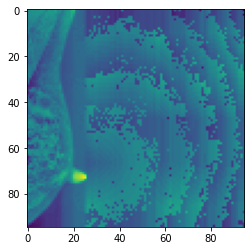

In [11]:
image = train_features[6214]
plt.imshow(image)
print(train_target[6214])

In [12]:
from keras.models import Sequential
from keras.layers import LeakyReLU
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D, Dropout, GlobalMaxPooling2D

model = Sequential()

model.add(Conv2D(64, 3, activation = "relu", input_shape = (95,95,1)))
model.add(MaxPooling2D())
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.2))

model.add(Conv2D(64, 3, activation = "relu"))
model.add(MaxPooling2D())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))

model.add(Conv2D(64, 3, activation = "relu"))
model.add(MaxPooling2D())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))

model.add(Conv2D(128, 3, activation = "relu"))
model.add(MaxPooling2D())
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.1))


model.add(Flatten())

model.add(Dense(1024, activation = 'relu')) 
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.2))

model.add(Dense(512, activation = 'relu')) 
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.3))

model.add(Dense(256, activation = 'relu')) 
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.3))

model.add(Dense(1, activation = 'sigmoid'))




from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives )
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives )
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))





#loss = tf.keras.losses.BinaryFocalCrossentropy(\
#    apply_class_balancing=True, gamma=5, from_logits=True,\
#    reduction=tf.keras.losses.Reduction.NONE)


#model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001),\
#              loss= 'binary_crossentropy', metrics=['accuracy'])



2023-01-27 14:36:37.917634: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
#from tensorflow import keras
#model = keras.models.load_model("/kaggle/input/pre-trained-model-of-breast-cancer/trained_model_breast_cancer3.h5")


In [14]:

model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001),\
              loss= 'binary_crossentropy', metrics=['accuracy'])

weights = {0:1, 1:6}
model.fit(train_features, train_target,  class_weight=weights,validation_split=0.3,batch_size = 64,epochs=70)




2023-01-27 14:36:39.977002: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70
464/464 [==============================] - 286s 613ms/step - loss: 1.0803 - accuracy: 0.8620 - val_loss: 0.6361 - val_accuracy: 0.8867
Epoch 2/70
464/464 [==============================] - 284s 612ms/step - loss: 1.0721 - accuracy: 0.8597 - val_loss: 0.6357 - val_accuracy: 0.8387
Epoch 3/70
464/464 [==============================] - 283s 609ms/step - loss: 1.0661 - accuracy: 0.8214 - val_loss: 0.6943 - val_accuracy: 0.3643
Epoch 4/70
464/464 [==============================] - 282s 608ms/step - loss: 1.0578 - accuracy: 0.7726 - val_loss: 0.6608 - val_accuracy: 0.5485
Epoch 5/70
464/464 [==============================] - 284s 611ms/step - loss: 1.0453 - accuracy: 0.7387 - val_loss: 0.6364 - val_accuracy: 0.5943
Epoch 6/70
464/464 [==============================] - 284s 612ms/step - loss: 1.0315 - accuracy: 0.7081 - val_loss: 0.6631 - val_accuracy: 0.5170
Epoch 7/70
464/464 [==============================] - 284s 612ms/step - loss: 1.0102 - accuracy: 0.7019 - val_loss: 0.6139 -

In [15]:
model.save("/kaggle/working/trained_model_breast_cancer3.h5")

In [16]:
#from tensorflow import keras
#savedModel = keras.models.load_model("/kaggle/input/pre-trained-model-of-breast-cancer/trained_model_breast_cancer3.h5")



In [17]:
test_features=[]
for i in test['img_data']:
    i=np.array(i)
    test_features.append(i)
test_features=np.array(test_features)
 

    
#featureTransform = test_features.reshape(len(test_features), 6400)
scaler = StandardScaler()
#featureTransform =scaler.fit_transform(featureTransform)
norm_features= []
for i in range(len(test_features)):
    norm_features.append(scaler.fit_transform(test_features[i]))
test_features=np.array(norm_features)


#backTransform = featureTransform.reshape(len(test_features),80,80)
test_features = test_features.reshape(len(test_features),95,95,1)



test_target = np.array(test['cancer'])

In [18]:
pred = model.predict(test_features)
bin_pred = []
for i in pred:
    if i>=0.5:
        bin_pred.append(1)
    else:
        bin_pred.append(0)
bin_pred = np.array(bin_pred)


In [19]:
import sklearn
acc = sklearn.metrics.accuracy_score(test_target, bin_pred)
print(acc)

countzero=0
countone=0
countzerot=0
countonet=0
for i, j in zip(test_target, bin_pred):
    if i==0 and j==0:
        countzero+=1
    if i==1 and j==1:
        countone+=1
    if i==1:
        countonet+=1
    if i==0:
        countzerot+=1
print(countzero/countzerot,countone/countonet)

0.9574081216595955
0.9548487683193015 0.9768211920529801


In [20]:

def recall_m(y_true, y_pred):
    true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    possible_positives = np.sum(np.round(np.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives )
    return recall

def precision_m(y_true, y_pred):
    true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    predicted_positives = np.sum(np.round(np.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives )
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))


print(f1_m(test_target,bin_pred))

0.842341423618193


In [21]:
datasetPath = '/kaggle/input/rsna-breast-cancer-detection/test.csv'
imgPath = '/kaggle/input/rsna-breast-cancer-detection/test_images/'

testImgData = dcmToPix(datasetPath, imgPath)

 75%|███████▌  | 3/4 [00:00<00:00,  8.09it/s]


In [22]:
datacancer = pd.read_csv(datasetPath)
imgDataFrame = {'img_data':testImgData}
imgData2 = pd.DataFrame(imgDataFrame)
testImgData=imgData2
imgdata_shuff = testImgData.sample(frac=1)

In [23]:
imgDataList=[]
for j in tqdm(imgdata_shuff['img_data']):
    imgDataList.append(random_rotate(j))
imgdata_shuff['img_data'] = imgDataList

100%|██████████| 4/4 [00:00<00:00, 2159.79it/s]


In [24]:
test=imgdata_shuff


test_features=[]
for i in test['img_data']:
    i=np.array(i)
    test_features.append(i)
test_features=np.array(test_features)
 
#featureTransform = test_features.reshape(len(test_features), 6400)
scaler = StandardScaler()
#featureTransform =scaler.fit_transform(featureTransform)
norm_features= []
for i in range(len(test_features)):
    norm_features.append(scaler.fit_transform(test_features[i]))
test_features=np.array(norm_features)


#backTransform = featureTransform.reshape(len(test_features),80,80)
test_features = test_features.reshape(len(test_features),95,95,1)




In [25]:
pred = model.predict(test_features)
bin_pred = []
for i in pred:
    if i>=0.5:
        bin_pred.append(1)
    else:
        bin_pred.append(0)
bin_pred = np.array(bin_pred)
print(bin_pred)

[0 0 0 0]


In [26]:
testData = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')

submissionFrame={'prediction_id':testData['prediction_id'],'cancer':bin_pred}
submission = pd.DataFrame(submissionFrame)
print(submission)

  prediction_id  cancer
0       10008_L       0
1       10008_L       0
2       10008_R       0
3       10008_R       0
